In [ ]:
# TODO: RA & Name 
print('198105: ' + 'Giovanni Torres Chaves')
print('178797: ' + 'Leticia Domingos Duarte')
print('221418: ' + 'Marcelo da Silva Lourenço')
print('222854: ' + 'Nathan Brusamarello de Souto')

198105: Giovanni Torres Chaves
178797: Leticia Domingos Duarte
221418: Marcelo da Silva Lourenço
222854: Nathan Brusamarello de Souto


In [ ]:
from google.colab import drive # importando drive para pegar os dados
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Bibliotecas
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
!pip install tensorflow
import os
import numpy as np
import tensorflow as tf
import sklearn as sk
from sklearn import metrics
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


1) Dados



1.1) Importando os dados

Devido termos utilizado a pasta "test" para validação, fomos atrás de outras imagens de Raio-X para utilizarmos como teste final. Achamos um outro banco de dados, porém, tivemos a surpresa de ser o mesmo banco com um autor diferente e nome nas imagens diferentes.

Buscamos outros bancos de fotos, porém não tivemos muito tempo para isso (descobrimos essa falha em 2021 já). Então, retiramos 10% dos dados de treino ("train") e utilizamos como teste.

Isso foi feito a mão, a retirada foi simples (simplesmente selecionamos 10% aleatoriamente dentro da pasta e realocamos essas fotos para a pasta "test"). Antes dessa realocação, a antiga pasta teste se tornou a pasta "val". (obs: esse valores são aproximados)

Portanto a dinâmica final dos dados foi:

90% Pasta "train" --> Pasta "train"

Pasta "test" --> Pasta "val"

10% Pasta "train" --> Pasta "test"

In [ ]:
#Diretórios
train_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/train/')
val_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/val/')

# Diretório train X-ray images
train_normal_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/train/NORMAL')
train_pneumonia_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/train/PNEUMONIA')

# Diretório val X-ray images
val_normal_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/val/NORMAL')
val_pneumonia_dir = os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/val/PNEUMONIA')

In [ ]:
#Nomes das imagens
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)

In [ ]:
#Número de imagens de treino e validação
print('Total de imagens de treino normal:', len(os.listdir(train_normal_dir)))
print('Total de imagens de treino pneumonia:', len(os.listdir(train_pneumonia_dir)))

print('Total de imagens de validação normal:', len(os.listdir( val_normal_dir ) ))
print('Total de imagens de validação pneumonia:', len(os.listdir( val_pneumonia_dir) ))

Total de imagens de treino normal: 1214
Total de imagens de treino pneumonia: 3645
Total de imagens de validação normal: 234
Total de imagens de validação pneumonia: 390


1.2) Manipulando os dados 

Aqui, aplicamos um filtro para facilitar a detecção da pneumonia. O algoritmo do modelo irá aplicá-lo, utilizando a escala "RGB" para facilitar esse processo.
A imagem a seguir representa essa manipulação com relação a cor.

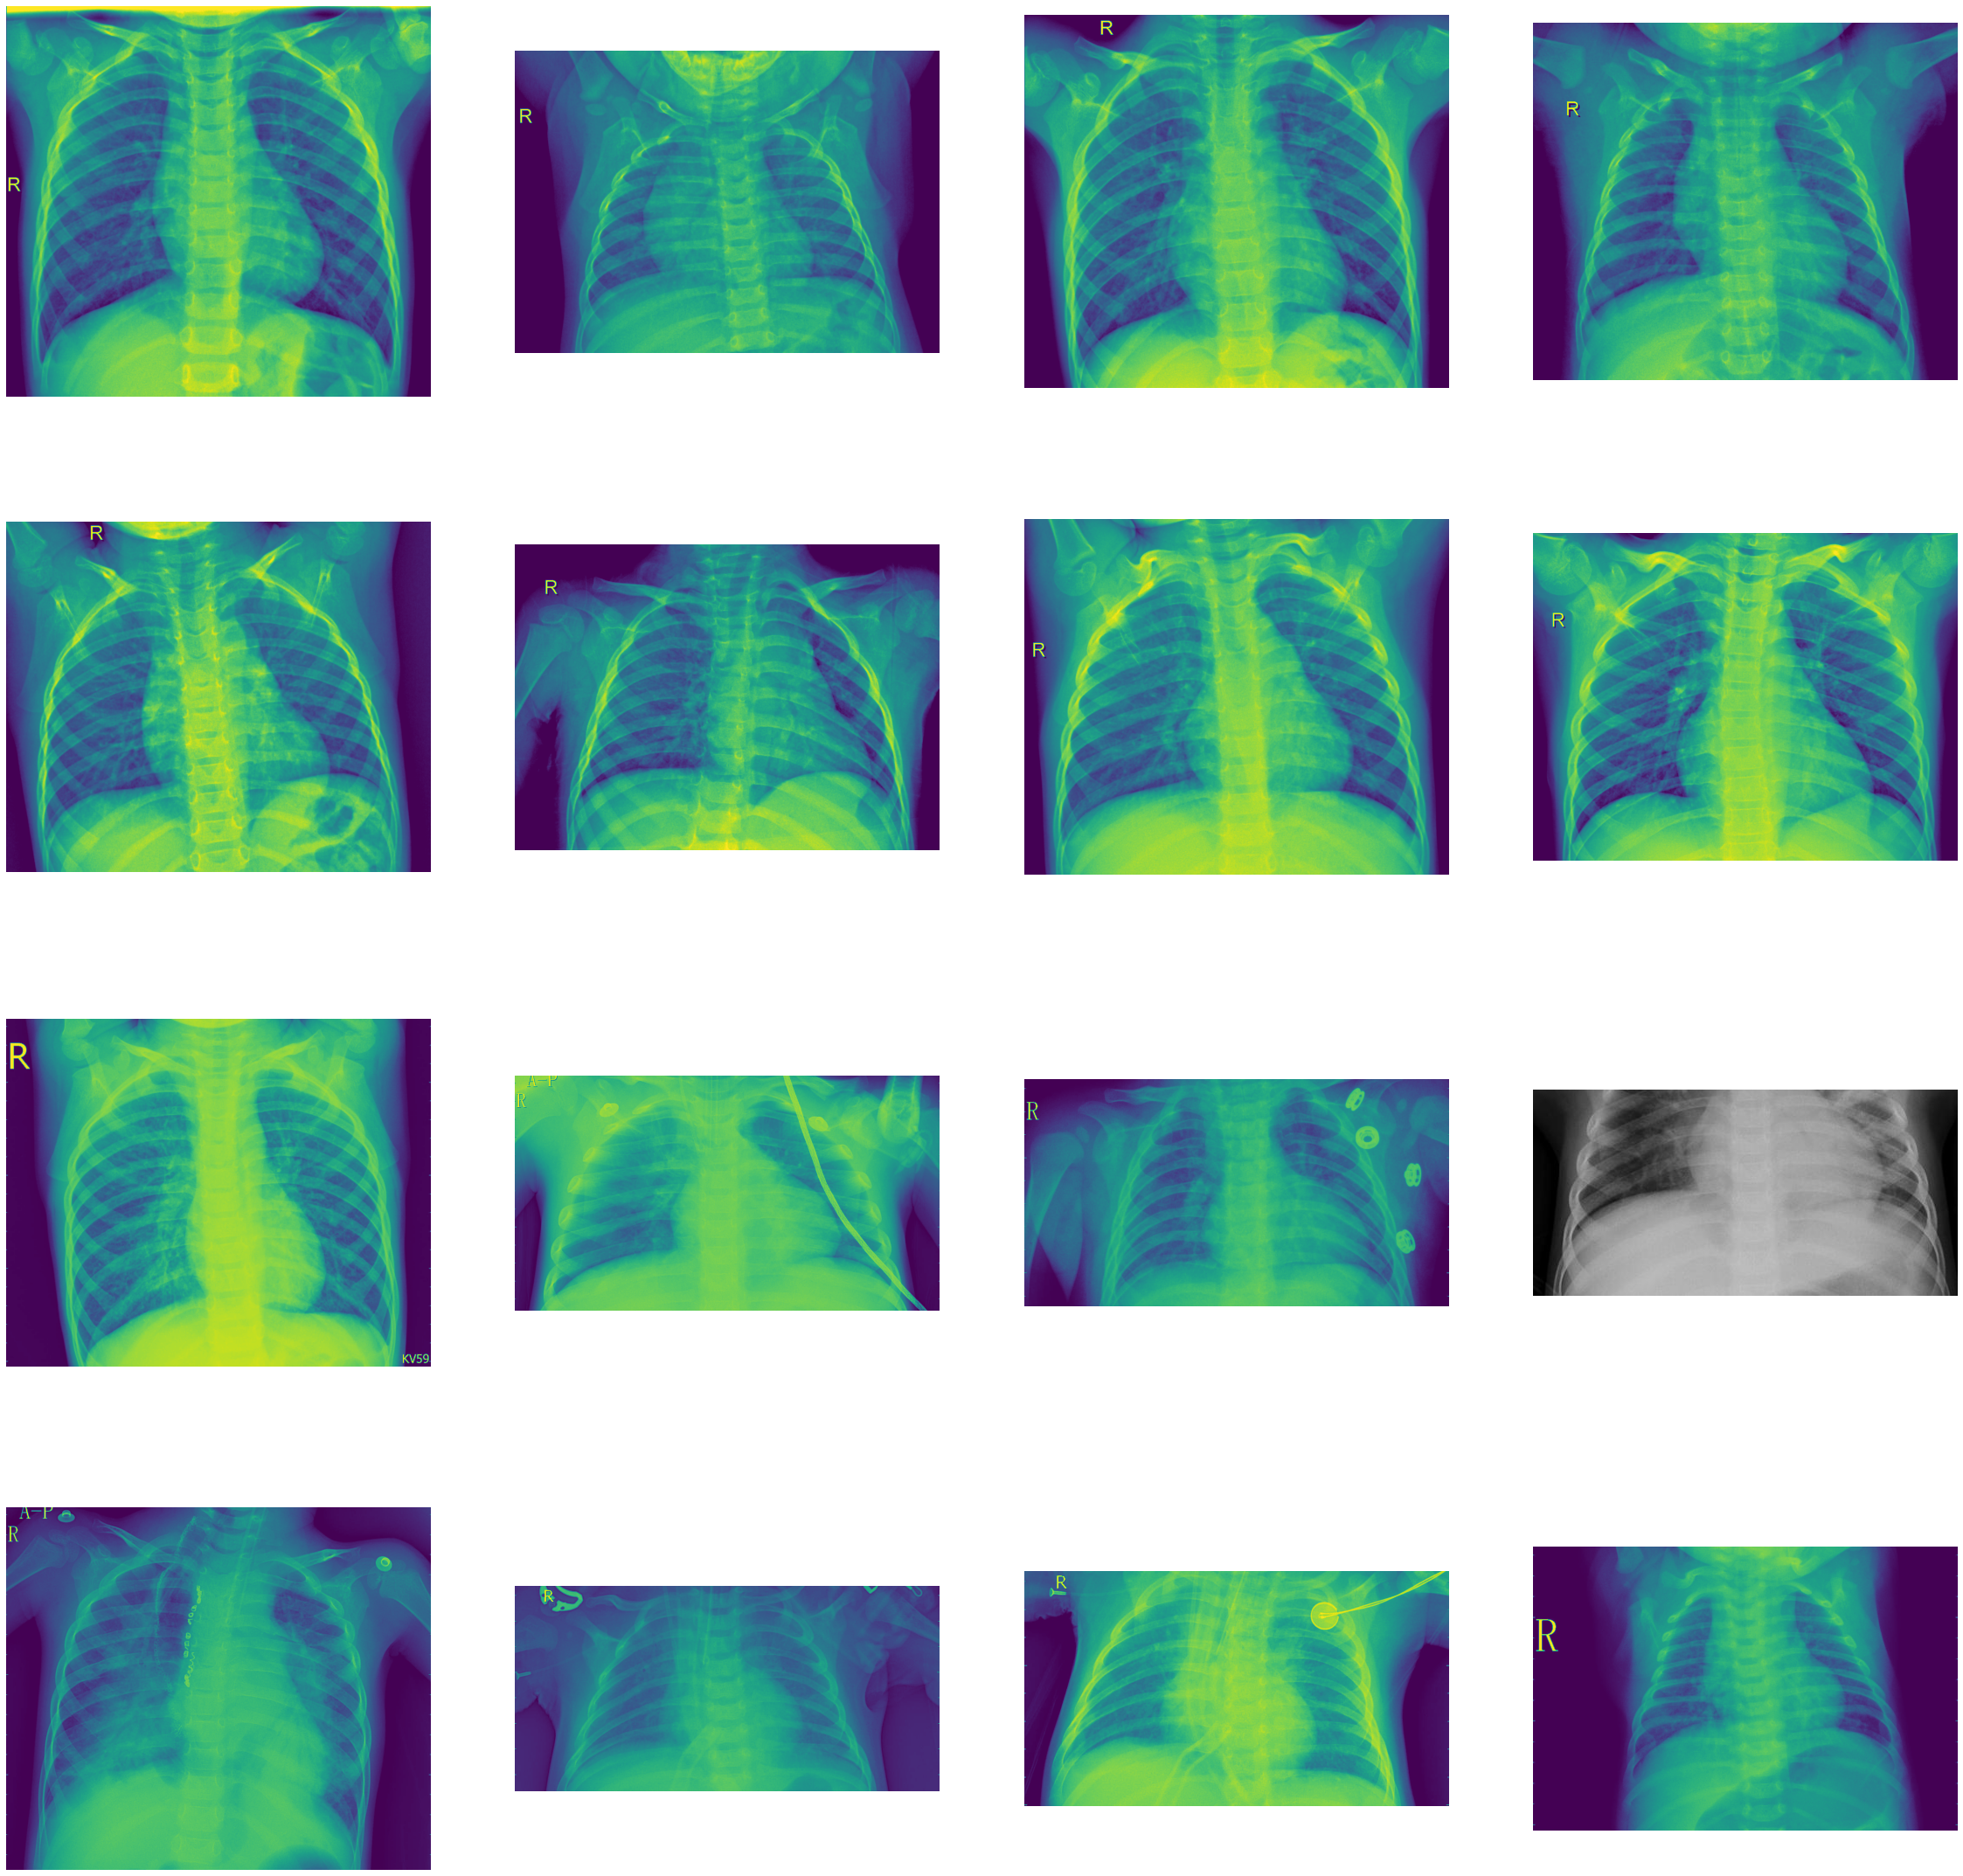

In [ ]:
nrows = 4
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 10, nrows * 10)

pic_index += 8
next_normal_pix = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_fnames[pic_index-8:pic_index]]
next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname) 
                for fname in train_pneumonia_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Da mesma forma que é necessária uma manipulação das cores, é preciso uma manipulação no tamanho da imagem para termos um padrão para adentrar o algoritmo. O código a seguir, é uma forma de reescalar essas fotos para o padrão adotado. 

Nosso padrão foi: 224 pixels x 224 pixels

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Todas as imagens vão ser reescaladas para 1/225
train_datagen = ImageDataGenerator( rescale = 1.0/255., #Transformando os pixels da imagem que estavam entre 0 e 255 para 0 a 1(divisao por 255)
                                   rotation_range = 40, #Rotaciona a imagem aleatoriamente entre [-40, 40] graus
                                   width_shift_range = 0.2, #Muda a largura da imagem
                                   height_shift_range = 0.2, #Muda a altura da imagem
                                   shear_range = 0.2, #Intensidade da deformidade ao longo de algum eixo
                                   zoom_range = 0.2, #as imagens são alongadas aleatoriamente na horizontal ou na vertical.
                                   horizontal_flip = True) # inverte a imagem ex: b|d

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. ,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
# --------------------
# Imagens de treinamento de fluxo em batches de tamanho 64 usando train_datagen generator
# --------------------

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(224, 224)) #Tamanho da imagem
# --------------------
# Flow validation images in batches of 64 using val_datagen generator
# --------------------
validation_generator =  validation_datagen.flow_from_directory(val_dir,
                                                         batch_size=64,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 4859 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


1.3) Considerações sobre os dados
Temos duas classes apenas ("NORMAL" e "PNEUMONIA"), sendo que nos dados de treino temos 4859 imagens e nos dados de teste temos 624. Sendo assim, usaremos uma rede neural com função de ativação logística, para poder classificar entre NORMAL ou PNEUMONIA.

2)Modelos

In [ ]:
# Modelo pré-treinado sem as camadas densas
model = tf.keras.applications.VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Definindo layers
full_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1024, kernel_initializer='he_uniform'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024,kernel_initializer='he_uniform'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1,activation='sigmoid')
])

full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [ ]:
# Criando callback_list pra evitar processamento desnecessários

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 3,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
# Instancia um otimizador Adam, compila e treina o modelo completo
adam = tf.keras.optimizers.Adam(lr=0.001)

full_model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=[tf.keras.metrics.AUC(name = 'auc')])

history = full_model.fit(train_generator,validation_data = validation_generator,
                   epochs = 20,
                   steps_per_epoch = 10,
                   verbose=1,
                   callbacks = callback_list)

Epoch 1/20
10/10 [==============================] - 35s 3s/step - loss: 0.6260 - auc: 0.7654 - val_loss: 0.4556 - val_auc: 0.8898

Epoch 00001: val_auc improved from -inf to 0.88979, saving model to ./best_weights.hdf5
Epoch 2/20
10/10 [==============================] - 27s 3s/step - loss: 0.2981 - auc: 0.9451 - val_loss: 0.4227 - val_auc: 0.9369

Epoch 00002: val_auc improved from 0.88979 to 0.93693, saving model to ./best_weights.hdf5
Epoch 3/20
10/10 [==============================] - 27s 3s/step - loss: 0.3229 - auc: 0.9328 - val_loss: 0.4486 - val_auc: 0.9430

Epoch 00003: val_auc improved from 0.93693 to 0.94300, saving model to ./best_weights.hdf5
Epoch 4/20
10/10 [==============================] - 27s 3s/step - loss: 0.2002 - auc: 0.9742 - val_loss: 0.4776 - val_auc: 0.9328

Epoch 00004: val_auc did not improve from 0.94300
Epoch 5/20
10/10 [==============================] - 27s 3s/step - loss: 0.2846 - auc: 0.9486 - val_loss: 0.4828 - val_auc: 0.9331

Epoch 00005: val_auc did 

Text(0.5, 1.0, 'Perda do treino e validação')

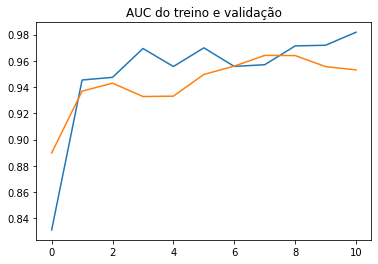

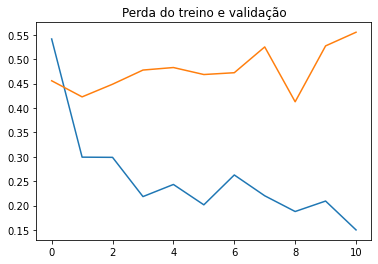

In [ ]:
# Criando os gráficos do AUC e perda durante o treino e a validação

acc      = history.history[     'auc' ]
val_acc  = history.history[ 'val_auc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) 
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('AUC do treino e validação')
plt.figure()

plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Perda do treino e validação'   )

##Analisando Teste

In [ ]:
# Definindo algoritmo de resultado clínico das imagens

def resultado(path):
  img = cv2.imread(path) #lendo a imagem
  plt.imshow(img) # print da imagem
  img = cv2.resize(img,(224, 224)) # alterando o tamanho da imagem para 224x224
  img = np.reshape(img,[1,224, 224,3]) # alterando o tamanho novamente com 3 cores

  classes = full_model.predict_classes(img) # previsão de resultado clínico

  print(classes) # saída do resultado
  if classes[0]>0:
      print("Esse é um Raio X de um paciente com pneumonia")
  else :
      print("Esse é um Raio X de um paciente normal (sem pneumonia)")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[0]]
Esse é um Raio X de um paciente normal (sem pneumonia)


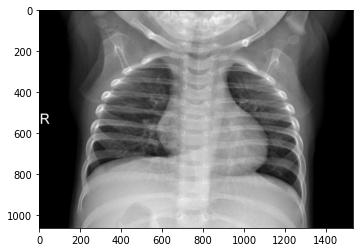

In [ ]:
# Exemplo Normal
resultado('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/test/NORMAL/NORMAL-9951946-0001.jpeg')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[1]]
Esse é um Raio X de um paciente com pneumonia


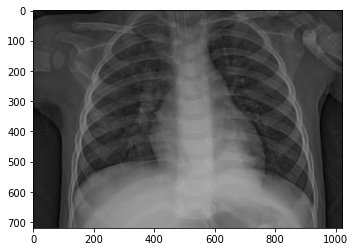

In [ ]:
#Exemplo Pneumonia
resultado('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/test/PNEUMONIA/Cópia de VIRUS-8967096-0002.jpeg')

In [ ]:
list_norm = os.listdir(os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/test/NORMAL')) #coletando o diretorio da pasta NORMAL do teste

y = np.repeat(0, len(list_norm))
pred = np.array([])

soma_norm = 0

for i in list_norm: #algoritmo que vai passar em todas as fotos trazendo o resultado
  img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/test/NORMAL/' + i)
  img = cv2.resize(img,(224, 224))
  img = np.reshape(img,[1,224, 224,3])
  classes = full_model.predict_classes(img)
  pred = np.append(pred, np.array(classes))
  soma_norm += classes

print(int(soma_norm)) # Total de erros na pasta NORMAL
print(len(list_norm)) # total de fotos na pasta NORMAL

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7
135


In [ ]:
list_pneu = os.listdir(os.path.join('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/test/PNEUMONIA')) #coletando o diretorio da pasta PNEUMONIA do teste

y2 = np.repeat(1, len(list_pneu))
y = np.append(y,y2)

soma_pneu = 0

for i in list_pneu:
  img = cv2.imread('/content/drive/My Drive/Colab Notebooks/Projeto final/chest_xray/test/PNEUMONIA/' + i)
  img = cv2.resize(img,(224, 224))
  img = np.reshape(img,[1,224, 224,3])
  classes = full_model.predict_classes(img)
  pred = np.append(pred, np.array(classes))
  soma_pneu += classes

print(len(list_pneu) - int(soma_pneu)) # Total de erros na pasta PNEUMONIA
print(len(list_pneu)) # total de fotos na pasta PNEUMONIA


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


59
388


Resultados Finais:

In [ ]:
acertos = (len(list_norm) - int(soma_norm)) + int(soma_pneu)
total = len(list_norm) + len(list_pneu) 
print(acertos/total) # acurácia final

sk.metrics.roc_auc_score(y,pred) #AUC

0.8738049713193117


0.8980431462390226